In [2]:
from pathlib import Path
import pandas as pd
from collections import defaultdict
import matplotlib.pylab as plt
from scipy.stats import spearmanr, pearsonr
from scipy.stats import ttest_ind, mannwhitneyu, ranksums, wilcoxon
import numpy as np
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm


In [3]:
def _read_egg_files(src_dir, ext, desc):
    fnames = src_dir.rglob('*' + ext)
    fnames = [x for x in fnames if not x.name.startswith('.')]
    
    data = {}
    for fname in tqdm(fnames, desc = desc):
        df = pd.read_csv(fname)
        bn = fname.name[:-len(ext)]
        data[bn] = df
        
    return data

bn = 'AUG_worm-eggs-adam-masks+Feggs+roi128+hard-neg-5_clf+unet-simple_maxlikelihood_20190808_151948_adam_lr0.000128_wd0.0_batch64'
features_dir = Path.home() / 'workspace/WormData/screenings/pesticides_adam/'
events_dir = Path.home() / 'workspace/WormData/egg_laying/plates/predictions/syngenta' / bn

metadata_file = features_dir / 'Syngenta_Master_Metadata.csv'

files_data = pd.read_csv(metadata_file)
files_data.dropna(subset = ['File_Name'], inplace = True)
files_data['File_Name'] = files_data['File_Name'].map(lambda x : x.rpartition('.')[0])

targets = _read_egg_files(features_dir, '_eggs.csv', 'Reading Ground Truth Files')   
predictions = _read_egg_files(events_dir, '_eggs_full.csv', 'Reading Predictions Files')


Reading Predictions Files: 100%|██████████| 1815/1815 [02:44<00:00, 11.06it/s]


In [4]:
train_dir = Path.home() / 'workspace/localization/data/worm_eggs_with_masks/train'

_ext = '_eggs.hdf5'
train_files = train_dir.rglob('*' + _ext)
training_basenames = list(set([x.name[:-len(_ext)].partition('_')[-1] for x in train_files]))

In [5]:
def missing_files(name_A, A, name_B, B, _print_files = False):
    _missing = set(A) - set(B)
    print(f'Missing {name_A} in {name_B} : {len(_missing)}')
    if _print_files:
        print(_missing)
        
missing_files('targets', targets.keys(), 'metadata', files_data['File_Name'].values)
missing_files('predictions', predictions.keys(), 'metadata', files_data['File_Name'].values)
missing_files('predictions', predictions.keys(), 'targets', targets.keys())
missing_files('targets', targets.keys(), 'predictions', predictions.keys())

Missing targets in metadata : 31
Missing predictions in metadata : 73
Missing predictions in targets : 738
Missing targets in predictions : 3


In [6]:
def _df2counts(x):
    x = x['frame_number'].value_counts()
    x = {i:c for i,c in zip(x.index, x.values)}
    return x


annotated_preds = {k:v for k,v in predictions.items() if k in targets}
#annotated_preds = {k:v for k,v in annotated_preds.items() if not k in training_basenames}


print(len(annotated_preds.keys()))

weird_files = []
results_annotated = defaultdict(list)
for k, preds in annotated_preds.items():
    tt = _df2counts(targets[k])
    #the annotations only add the new frames, so i need the cumsum
    true_counts = {}
    cur = 0
    for i in range(5):
        if i in tt:
            cur += tt[i]
        true_counts[i] = cur

    pred_counts = _df2counts(preds)
    
    for frame in range(5):
        ct = true_counts[frame] if frame in true_counts else 0
        cp = pred_counts[frame] if frame in pred_counts else 0

        if ct > 0 and cp == 0:
            weird_files.append((k, frame))

        results_annotated[frame].append((ct, cp))



1077


Frame = 0
Spearman Coeff = 0.9780178124305483
Pearson Coeff = 0.9830354056570367
Frame = 1
Spearman Coeff = 0.9800948095752983
Pearson Coeff = 0.9822474254939136
Frame = 2
Spearman Coeff = 0.9825022956854764
Pearson Coeff = 0.9832306189903081
Frame = 3
Spearman Coeff = 0.981936209920667
Pearson Coeff = 0.9839494438557904
Frame = 4
Spearman Coeff = 0.9784899163618104
Pearson Coeff = 0.9820097445787648


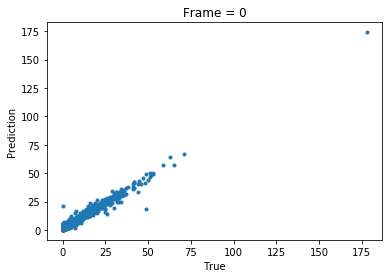

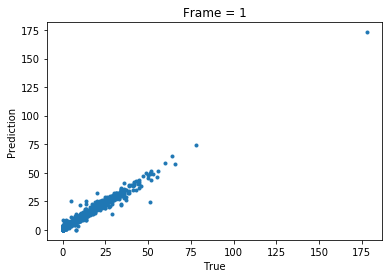

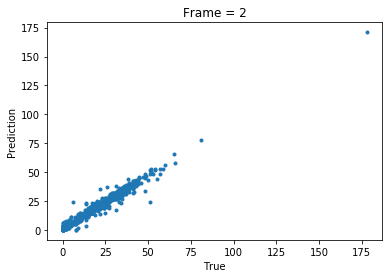

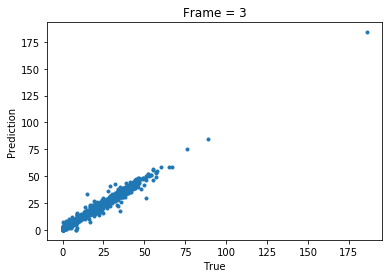

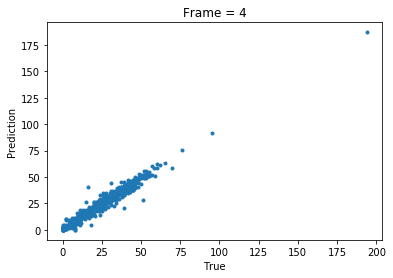

In [7]:
#I only trained on the frame 0. So I am using the rest to check the trainig performance
for k in range(5):
    true, pred = zip(*results_annotated[k])

    plt.figure()
    plt.plot(true, pred, '.')

    plt.xlabel('True')
    plt.ylabel('Prediction')

    plt.title(f'Frame = {k}')


    print(f'Frame = {k}')
    spearman_coeff, spearman_pval = spearmanr(true, pred)
    pearson_coeff, pearson_pval = pearsonr(true, pred)

    print(f'Spearman Coeff = {spearman_coeff}')
    print(f'Pearson Coeff = {pearson_coeff}')

In [9]:
#bn2check = set(predictions.keys()) & set(files_data['File_Name'].values)
results_all = []
for _, row in files_data.iterrows():
    bn = row['File_Name']
    if not bn in predictions:
        continue
    df = predictions[bn]
    counts = _df2counts(df)
    
    if 'No_Compound' in bn:
        strain, n_worms = bn.split('_')[:2]
        drug = 'No_Compound' 
        concentration  = 0
    else:
        strain, n_worms, _, _ = bn.split('_')[:4]
    try:
        n_worms = int(n_worms[5:])
    except:
        n_worms = np.nan
    
    results_all += [(bn, strain, n_worms, row['Drug_ID'], row['Drug_Name'], row['Concentration'], k, v) for k,v in counts.items()]


results_all = pd.DataFrame(results_all, columns = ['basename', 'strain', 'n_worms', 'drug_id', 'drug', 'concentration', 'frame', 'counts'])

results_all

,basename,strain,n_worms,drug_id,drug,concentration,frame,counts
0,N2_worms10_DMSO_14.08_Set1_Pos4_Ch1_14072017_1...,N2,10.0,DMSO,DMSO,14.0791,4,11
1,N2_worms10_DMSO_14.08_Set1_Pos4_Ch1_14072017_1...,N2,10.0,DMSO,DMSO,14.0791,3,11
2,N2_worms10_DMSO_14.08_Set1_Pos4_Ch1_14072017_1...,N2,10.0,DMSO,DMSO,14.0791,2,10
3,N2_worms10_DMSO_14.08_Set1_Pos4_Ch1_14072017_1...,N2,10.0,DMSO,DMSO,14.0791,1,10
4,N2_worms10_DMSO_14.08_Set1_Pos4_Ch1_14072017_1...,N2,10.0,DMSO,DMSO,14.0791,0,10
...,...,...,...,...,...,...,...,...
8444,Set66_Ch6_16032019_132544,Set66,NaN,DE,CSAA398011,150.0000,3,35
8445,Set66_Ch6_16032019_132544,Set66,NaN,DE,CSAA398011,150.0000,4,34
8446,Set66_Ch6_16032019_132544,Set66,NaN,DE,CSAA398011,150.0000,2,32
8447,Set66_Ch6_16032019_132544,Set66,NaN,DE,CSAA398011,150.0000,1,32


In [47]:
for  frame2check in range(5):
    is_ctr = (results_all['drug'] == 'DMSO') 
    ctr = results_all[is_ctr]
    res = results_all[~is_ctr]

    res = res[(res['frame'] == frame2check)]
    ctr = ctr[(ctr['frame'] == frame2check)]

    pvals = []

    b = ctr['counts'].values

    for key, dat in res.groupby(['drug', 'concentration']):
        if len(dat) < 3:
            continue
        
        a = dat['counts'].values
        t, prob = ttest_ind(a, b)
        #t, prob = ranksums(a,b)
        #t, prob = mannwhitneyu(a, b, use_continuity = False, alternative = 'two-sided')#'less')#'less')#, alternative = 'two-sided')
        
        pvals.append((*key, prob, np.mean(a)))
        
        
    pvals = pd.DataFrame(pvals, columns = ['drug', 'concentration', 'pval', 'eggs_mean'])
    _, pvals['pval_corr'], _, _ = multipletests(pvals['pval'].values, method = 'fdr_bh')
    
    pvals = pvals.sort_values(by = 'pval_corr')
    
    print(f'Frame = {frame2check}')
    print(f'DMSO mean number of eggs: {np.mean(b):.2f}±{np.std(b):.2f}')
    print(pvals[pvals['pval_corr']<0.1])
    
    

Frame = 0
DMSO mean number of eggs: 11.79±7.60
            drug  concentration          pval  eggs_mean     pval_corr
53    CSAA026102          100.0  1.474814e-12  48.666667  7.359321e-10
45    CSAA021296            1.0  8.819210e-12  47.333333  2.200393e-09
298   CSCC202642            0.1  5.382203e-11  76.333333  8.952398e-09
52    CSAA026102           10.0  3.074374e-10  43.333333  3.835282e-08
51    CSAA026102            1.0  1.390018e-09  42.000000  1.387238e-07
47    CSAA021296          100.0  1.704109e-08  39.333333  1.417250e-06
461   CSCD702471            1.0  8.386534e-08  37.666667  5.978401e-06
29    CSAA016712            1.0  3.173235e-07  37.333333  1.979305e-05
498  No_Compound            0.0  6.425967e-07  28.857143  3.562841e-05
488   CSDH053139           10.0  9.779786e-07  35.333333  4.880113e-05
46    CSAA021296           10.0  3.860977e-06  35.000000  1.751479e-04
27    CSAA012836          100.0  1.282642e-05  34.666667  5.333652e-04
183   CSAA398011           30.

Frame = 3
DMSO mean number of eggs: 19.03±10.89
            drug  concentration          pval  eggs_mean  pval_corr
290   CSCC202642            0.1  7.809495e-09  82.666667   0.000004
54    CSAA026102          100.0  5.214498e-06  50.000000   0.000846
46    CSAA021296            1.0  4.567505e-06  50.333333   0.000846
476   CSDH053139           10.0  1.994636e-05  48.000000   0.001943
43    CSAA020833           30.0  1.743198e-05  48.000000   0.001943
397   CSCD532488          150.0  6.505467e-05   3.666667   0.005280
53    CSAA026102           10.0  1.005112e-04  45.000000   0.005700
396   CSCD532488          100.0  9.309354e-05   4.000000   0.005700
475   CSDH053139            3.0  1.053466e-04  47.333333   0.005700
28    CSAA012836          100.0  1.264319e-04  46.000000   0.006131
394   CSCD532488           10.0  1.384798e-04   4.444444   0.006131
10    CSAA008422           30.0  3.034747e-04  43.000000   0.012316
180   CSAA398011           30.0  3.546695e-04  43.333333   0.013286


In [48]:
all_diff = []
cols = ['basename', 'strain', 'n_worms', 'drug', 'concentration', 'diff_counts']
for bn, dat in results_all.groupby('basename'):
    dd = dat.copy()
    dd.index = dat['frame']

    try:
        ini = dd.loc[0]
        fin = dd.loc[4]
    except KeyError:
        continue

    count_diff = fin['counts'] - ini['counts']

    res = *[ini[x] for x in cols[:-1]], count_diff
    all_diff.append(res)

all_diff = pd.DataFrame(all_diff, columns = cols)
    

In [54]:
#%%
is_ctr = (all_diff['drug'] == 'DMSO') 
ctr = all_diff[is_ctr]
res = all_diff[~is_ctr]

pvals = []
    
b = ctr['diff_counts'].values
b[b<0] = 0
for key, dat in res.groupby(['drug', 'concentration']):
    if len(dat) < 3:
        continue


    a = dat['diff_counts'].values.copy()
    a[a<0] = 0
    #t, prob = ttest_ind(a, b)
    t, prob = mannwhitneyu(a, b)
    #t, prob = ranksums(a,b)

    pvals.append((*key, prob, np.mean(a)))


pvals = pd.DataFrame(pvals, columns = ['drug', 'concentration', 'pval', 'diff_eggs_mean'])
_, pvals['pval_corr'], _, _ = multipletests(pvals['pval'].values, method = 'fdr_bh')
pvals = pvals.sort_values(by = 'pval_corr')

print(f'DMSO mean number of eggs: {np.mean(b):.2f}±{np.std(b):.2f}')
print(pvals[pvals['pval_corr']<0.1])
pvals

DMSO mean number of eggs: 11.44±8.25
Empty DataFrame
Columns: [drug, concentration, pval, diff_eggs_mean, pval_corr]
Index: []


,drug,concentration,pval,diff_eggs_mean,pval_corr
162,CSAA383699,1.0,0.009050,0.666667,0.131084
66,CSAA035778,100.0,0.011410,1.000000,0.131084
413,CSCD675030,3.0,0.003353,25.666667,0.131084
409,CSCD668797,10.0,0.004189,0.000000,0.131084
408,CSCD668797,1.0,0.006707,0.333333,0.131084
...,...,...,...,...,...
129,CSAA172687,0.1,0.491312,11.333333,0.497802
319,CSCC818722,10.0,0.495656,11.333333,0.497802
187,CSAA465503,150.0,0.495656,11.333333,0.497802
403,CSCD653428,3.0,0.500000,10.666667,0.500000


Text(0,0.5,'Change eggs betweeen frame=0 to frame=4')

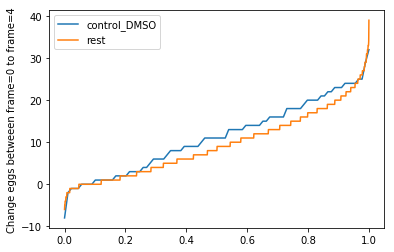

In [38]:
def counts_sorted(counts):
    yy = np.sort(counts)
    xx = np.linspace(0, 1, len(yy))
    return xx, yy


is_ctr_dmso = all_diff['drug'] == 'DMSO'
is_ctr_no_compound = all_diff['drug'] == 'No_Compound'
is_drug = ~(is_ctr_no_compound | is_ctr_dmso)



plt.figure()

#xx, yy = counts_sorted(all_diff['diff_counts'].values)
#plt.plot(xx, yy)

xx, yy = counts_sorted(all_diff.loc[is_ctr_dmso, 'diff_counts'].values)
plt.plot(xx, yy, label = 'control_DMSO')

#xx, yy = counts_sorted(all_diff.loc[is_ctr_no_compound, 'diff_counts'].values)
#plt.plot(xx, yy, label = 'no compound')

xx, yy = counts_sorted(all_diff.loc[is_drug, 'diff_counts'].values)
plt.plot(xx, yy, label = 'rest')

#print(all_diff.loc[is_ctr_no_compound, 'diff_counts'].values.size)
plt.legend()

plt.ylabel('Change eggs betweeen frame=0 to frame=4')


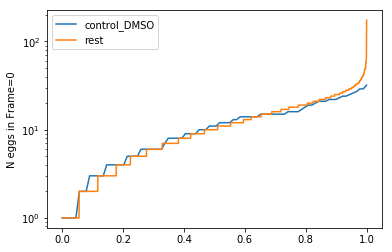

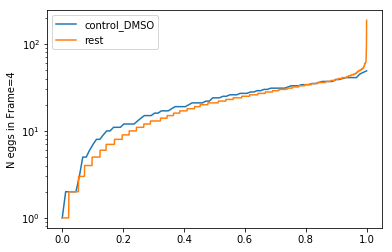

In [41]:
def counts_sorted(counts):
    yy = np.sort(counts)
    xx = np.linspace(0, 1, len(yy))
    return xx, yy


for i in [0, 4]:
    dat = results_all[results_all['frame'] == i]

    is_ctr_dmso = dat['drug'] == 'DMSO'
    is_ctr_no_compound = dat['drug'] == 'No_Compound'
    is_drug = ~(is_ctr_no_compound | is_ctr_dmso)

    plt.figure()

    #xx, yy = counts_sorted(dat['counts'].values)
    #plt.plot(xx, yy)

    xx, yy = counts_sorted(dat.loc[is_ctr_dmso, 'counts'].values)
    plt.plot(xx, yy, label = 'control_DMSO')

    #xx, yy = counts_sorted(dat.loc[is_ctr_no_compound, 'counts'].values)
    #plt.plot(xx, yy)

    xx, yy = counts_sorted(dat.loc[is_drug, 'counts'].values)
    plt.semilogy(xx, yy, label = 'rest')
    
    plt.legend()
    
    plt.ylabel(f'N eggs in Frame={i}')

In [24]:
print(results_all.loc[results_all['drug'] == 'DMSO', 'counts'].values.max())
print(all_diff.loc[all_diff['drug'] == 'DMSO', 'diff_counts'].values.max())

49
32
